### In this project we want to predict wether a person earns more than 50K USD per year (positive event) or less or equal to this amount 

- age: Age in years.
- workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- fnlwgt: Census weight assigned to an individual; continuous.
- education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- education-num: Number of years of education corresponding to education; continuous.
- marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- sex: Female, Male.
- capital-gain: Income from investment profits; continuous.
- capital-loss: Loss from investments; continuous.
- hours-per-week: Number of hours worked per week; continuous.
- native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
- income: <=50K, >50K (Target variable indicating whether the individual's annual income is above or below $50,000).

In [97]:

# Larger figures
import matplotlib.pyplot as plt
%matplotlib inline  

import warnings
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, f1_score, accuracy_score, precision_recall_curve, confusion_matrix, classification_report
from sklearn.metrics import recall_score, precision_score
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from IPython.display import display

from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_recall_curve, confusion_matrix, recall_score, precision_score
from sklearn.model_selection import cross_val_score
from matplotlib.ticker import FuncFormatter

import xgboost as xgb

Let's load the dataset and review null values

In [98]:
headers=['age','workclass', 'fnlwgt', 'education', 'education_num','marital_status','occupation','relationship','race','sex','capital_gain','capital_loss','hours_per_week','birth_country','income_over_50K']

In [99]:
#Import the data, include the headers, change '?' to None, and encode the target variable.
df = pd.read_csv('adult-all.csv', header=None, names=headers)
df['income_over_50K']=df['income_over_50K'].map({'>50K':1, '<=50K':0})
df['birth_country']=df['birth_country'].apply(lambda x: 1 if x=='United-States' else 0)
df.replace('?',None, inplace=True)
df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,birth_country,income_over_50K
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,1,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,1,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,1,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,1,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,0,0


Let's remove some of the variables that don't seem to hold that much relevance for us.

In [100]:
#Drop fnlwgt since it won't be useful for classification 
# (it represents the weigted representation of the population and since we're doing classification is irrelevant )
# and education as we have education_num for the same
df.drop(['fnlwgt','education'], axis=1,inplace=True)

In [101]:
#Visualize number of observations and columns, and column names
print ("Records and variables: ", df.shape)
print ("Column names: ", df.columns.to_list())

Records and variables:  (48842, 13)
Column names:  ['age', 'workclass', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'birth_country', 'income_over_50K']


In [102]:
#Let's get the percentage of null values
100*df.isnull().mean()

age                0.000000
workclass          5.730724
education_num      0.000000
marital_status     0.000000
occupation         5.751198
relationship       0.000000
race               0.000000
sex                0.000000
capital_gain       0.000000
capital_loss       0.000000
hours_per_week     0.000000
birth_country      0.000000
income_over_50K    0.000000
dtype: float64

In [103]:
#Before droppin variables let's see if the missing values from workclass, occupation and birth_country overlap or not. 
# If they do and missing values are more than 10% we need to take a different approach and impute the values 
100*df[~df['workclass'].isna()].isna().mean()

age                0.000000
workclass          0.000000
education_num      0.000000
marital_status     0.000000
occupation         0.021719
relationship       0.000000
race               0.000000
sex                0.000000
capital_gain       0.000000
capital_loss       0.000000
hours_per_week     0.000000
birth_country      0.000000
income_over_50K    0.000000
dtype: float64

Since the missing values don't overlap for the majority of the data, and those that do are less than 10%, we will simply drop them.

In [104]:
df.dropna(inplace=True)
print ("Records and variables: ", df.shape)

Records and variables:  (46033, 13)


In [105]:
#Now let's do some encoding for the categorical variables

from sklearn.preprocessing import OneHotEncoder

categorical_columns = list(df.select_dtypes(include=[object]).columns)

# Initialize One-Hot Encoder
encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")

# Fit and transform categorical columns
encoded_cols = encoder.fit_transform(df[categorical_columns])

# Convert encoded columns into a DataFrame
encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(categorical_columns))

# Drop original categorical columns from the DataFrame
df.drop(columns=categorical_columns, inplace=True)

# Concatenate the DataFrame with the encoded categorical columns
df = pd.concat([df, encoded_df], axis=1)

df.dropna(inplace=True)

df.head()


,age,education_num,capital_gain,capital_loss,hours_per_week,birth_country,income_over_50K,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,39.0,13.0,2174.0,0.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,50.0,13.0,0.0,0.0,13.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,38.0,9.0,0.0,0.0,40.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,53.0,7.0,0.0,0.0,40.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,28.0,13.0,0.0,0.0,40.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


Show % of records from each of the income class

In [110]:
from collections import Counter

def class_perc(data):
    lendata = len(data)
    classes = Counter(data)
    
    for sclass, freq in classes.items():
        perc = (freq / lendata) * 100
        print(f"Class '{sclass}': {perc:.2f}%", ", freq:",freq)

class_perc(df['income_over_50K'])

Class '0.0': 75.21% , freq: 32643
Class '1.0': 24.79% , freq: 10760


We are going to split it into training and test (with same class distribution of income variable in each set

In [111]:
#first define X and y for posterior analysis

X= df.drop('income_over_50K',axis=1)
y=df['income_over_50K']

In [112]:
def split_df(dataframe,y_column, seed=None, percentage=0.8):
    
    X = df.loc[:, dataframe.columns != y_column]
    y = df[y_column]

    return train_test_split(X, y, test_size=1-percentage, random_state=seed, stratify=y) # note the stratify parameter

X_train, X_test, Y_train, Y_test = split_df(df, seed=42, percentage=0.8, y_column='income_over_50K')

In [113]:
print("Training data set: ", X_train.shape)
print("Testing data set: ", X_test.shape)
class_perc(Y_train.to_frame(name='income_over_50K')["income_over_50K"])
class_perc(Y_test.to_frame(name='income_over_50K')["income_over_50K"])

Training data set:  (34722, 41)
Testing data set:  (8681, 41)
Class '0.0': 75.21% , freq: 26114
Class '1.0': 24.79% , freq: 8608
Class '0.0': 75.21% , freq: 6529
Class '1.0': 24.79% , freq: 2152


## Classification Tree

In [114]:
from sklearn.tree import DecisionTreeClassifier

clas_tree = DecisionTreeClassifier(criterion="entropy", random_state=42)
clas_tree.fit(X_train, Y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

Let's take a look to the performance of the classifier (by using initially Accuracy)

In [115]:
pred_train = clas_tree.predict(X_train)
print("Recall of training set = {0:.2%}".format(accuracy_score(Y_train, pred_train)))

pred_test = clas_tree.predict(X_test)
print("Recall of testing set = {0:.2%}".format(accuracy_score(Y_test, pred_test)))

Recall of training set = 98.35%
Recall of testing set = 76.42%


We can clearly see that our model is **overfitting**

In [116]:
# How many nodes and leaves?
print("Number of nodes: ", clas_tree.tree_.node_count)
print("Number of leaves: ", clas_tree.get_n_leaves())

Number of nodes:  15529
Number of leaves:  7765


We will plot the feature importance

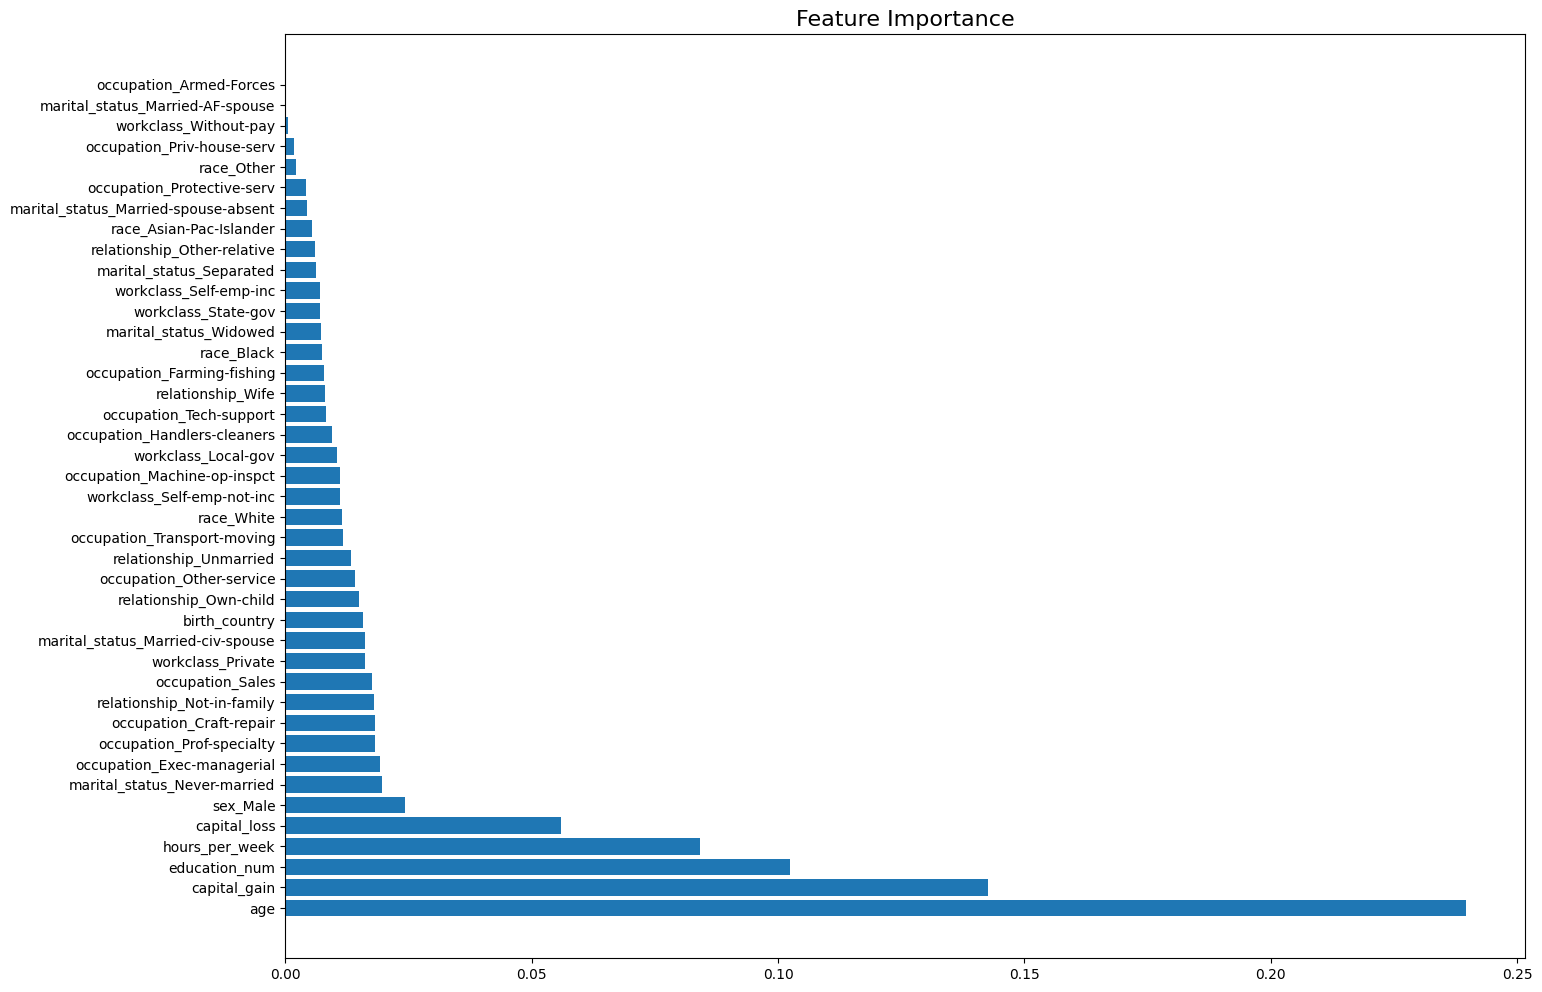

In [119]:
plt.figure(figsize=(16,12))
importances = clas_tree.feature_importances_
indices = np.argsort(importances)[::-1]
plt.barh(X_train.columns[indices], importances[indices]) #average reduction in impurity resulting from splitting at each node of the tree using that feature
#plt.xticks(rotation=90)
plt.title('Feature Importance', fontsize=16);

## Pruning the tree

The tree, as it is presented, will surely overfit.

Therefore, we will have to prune it to improve performance in the test set.

There are different Pruning Parameters:

 - max_leaf_nodes: Reduce the number of leaf nodes
 - min_samples_leaf: Restrict the size of sample leaf. Minimum sample size in terminal nodes can be fixed to a number or a % of total 
 - max_depth: Reduce the depth of the tree to build a generalized tree. Set the depth of the tree to different values depending after verification on test data
 - etc..

Let's focus for now on the depth of the tree and minimum samples per leaf. We will test different depth thresholds via CV (k-fold) by using the `GridSearchCV` provided by sklearn.

In [ ]:
from sklearn.model_selection import GridSearchCV

params_grid = {'max_depth': range(1,16), 'min_samples_leaf':range(1,11)} # 15 different depth levels

clas_tree_pruned_depth_cv = GridSearchCV(clas_tree, 
                   params_grid,
                   scoring='accuracy',
                   cv=5 , n_jobs=1, verbose=1)

clas_tree_pruned_depth_cv.fit(X_train,Y_train);

Fitting 5 folds for each of 735 candidates, totalling 3675 fits


In [121]:
print("Best parameters set found on development set:")
print()
print(clas_tree_pruned_depth_cv.best_params_)
print()
print("Grid scores on development set:")
print()
means = clas_tree_pruned_depth_cv.cv_results_['mean_test_score']
stds = clas_tree_pruned_depth_cv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clas_tree_pruned_depth_cv.cv_results_['params']):
    print("Recall = %0.3f (+/%0.03f) for %r" % (mean, std * 2, params))

Best parameters set found on development set:

{'max_depth': 10, 'min_samples_leaf': 6}

Grid scores on development set:

Recall = 0.794 (+/0.004) for {'max_depth': 1, 'min_samples_leaf': 1}
Recall = 0.794 (+/0.004) for {'max_depth': 1, 'min_samples_leaf': 2}
Recall = 0.794 (+/0.004) for {'max_depth': 1, 'min_samples_leaf': 3}
Recall = 0.794 (+/0.004) for {'max_depth': 1, 'min_samples_leaf': 4}
Recall = 0.794 (+/0.004) for {'max_depth': 1, 'min_samples_leaf': 5}
Recall = 0.794 (+/0.004) for {'max_depth': 1, 'min_samples_leaf': 6}
Recall = 0.794 (+/0.004) for {'max_depth': 1, 'min_samples_leaf': 7}
Recall = 0.794 (+/0.004) for {'max_depth': 1, 'min_samples_leaf': 8}
Recall = 0.794 (+/0.004) for {'max_depth': 1, 'min_samples_leaf': 9}
Recall = 0.794 (+/0.004) for {'max_depth': 1, 'min_samples_leaf': 10}
Recall = 0.794 (+/0.004) for {'max_depth': 1, 'min_samples_leaf': 11}
Recall = 0.794 (+/0.004) for {'max_depth': 1, 'min_samples_leaf': 12}
Recall = 0.794 (+/0.004) for {'max_depth': 1, '

### Test data set

Let's now calculate accuracy for test data set using the depth with maximum accuracy (using a default threshold of 50%)

In [ ]:
clas_tree_pruned = DecisionTreeClassifier(random_state=42, 
                                          max_depth=clas_tree_pruned_depth_cv.best_params_['max_depth'],
                                          min_samples_leaf=clas_tree_pruned_depth_cv.best_params_['min_samples_leaf']) 
tree=clas_tree_pruned.fit(X_train, Y_train)

predictions_test = tree.predict(X_test) # obtains predictions with a threshold=50%
print("Accuracy for the single Classification Tree = {0:.2%}".format(accuracy_score(Y_test, predictions_test)))

tree_acc=accuracy_score(Y_test, predictions_test)

Accuracy for the single Classification Tree = 82.99%


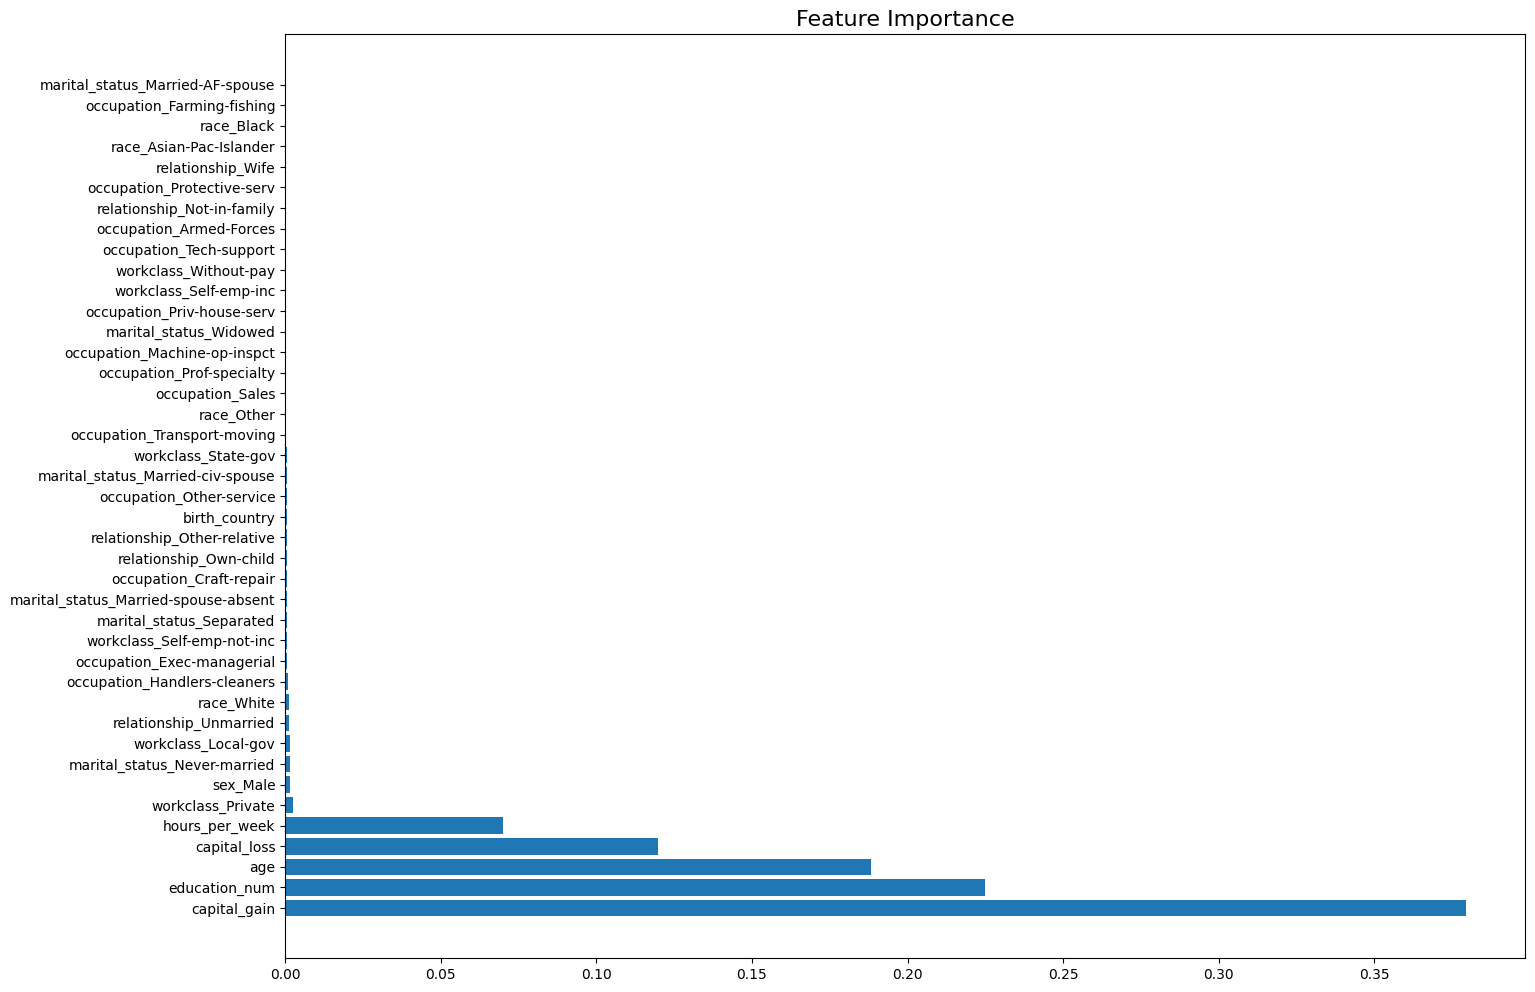

In [ ]:
plt.figure(figsize=(16,12))
importances = tree.feature_importances_
indices = np.argsort(importances)[::-1]
plt.barh(X_train.columns[indices], importances[indices]) #average reduction in impurity resulting from splitting at each node of the tree using that feature
plt.title('Feature Importance', fontsize=16);

Great! We have increased the accuracy of the test set with a smaller tree.

In [129]:
# How many nodes and leaves?
print("Number of nodes: ", clas_tree_pruned.tree_.node_count)
print("Number of leaves: ", clas_tree_pruned.get_n_leaves())

Number of nodes:  503
Number of leaves:  252


# Bagging

In [ ]:
baseRF = RandomForestClassifier(n_estimators = 200,  # The number of trees in the forest
                               random_state = 0, # This parameter allows to replicate results
                               n_jobs = -1, # The number of jobs to run in parallel (-1 means all processors, 1 no parallelism)
                               oob_score = True) # Whether to use out-of-bag samples to estimate the generalization score (increases time)

# The OOB score is an estimate of the generalization error of the model, calculated with the data not used to train it.
# Since each tree is trained on a bootstrapped sample, they all use approximately 2/3 of the data (this is a mathematical consequence 
# of random sampling with replacement). Therefore, for each of the learners we have 1/3 of the dataset as Out Of Bag (OOB) observations 
# which can be used to test the model and estimate its generalisation error. By averaging these OOB error estimates across the trees, 
# RF produces a robust error estimate for the ensemble during training time at almost no additional computational cost.

# other parameters:
# criterion{"gini", "entropy", "log_loss"}, default="gini"
# max_depth: int, default=None
# min_samples_leaf: int or float, default=1 - The minimum number of samples required to be at a leaf node
# min_samples_split: int or float, default=2 - The minimum number of samples required to split an internal node:
# max_features{"sqrt", "log2", None}, int or float, default="sqrt" - The number of features to consider when looking for the best split

baseRF.fit(X_train,Y_train)

# predictions
y_pred_bagging_test = baseRF.predict(X_test)

print("Accuracy for Bagging = {0:.2%}".format(accuracy_score(Y_test, y_pred_bagging_test)))

bagging_acc=accuracy_score(Y_test,y_pred_bagging_test)

Accuracy for Bagging = 81.07%


In [133]:
param_grid = {
    'min_samples_leaf' :[4,6,8], 
    'max_features' : [4,8,12,16],
    'criterion' : ['gini','entropy'] #,'log_loss']
}

In [134]:
import time 
start_time = time.time()

from sklearn.model_selection import GridSearchCV
cvRF = GridSearchCV(estimator=baseRF, param_grid=param_grid, cv=5, scoring='roc_auc') 
#cv is the number of cross validation iterations to be performed
cvRF.fit(X_train,Y_train)

print ("Completed in {:0.0f} seconds ".format((time.time() - start_time)))

Completed in 452 seconds 


In [135]:
# shows the best combination of criteria found
best_params = cvRF.best_params_
print("Best parameters:", best_params)

Best parameters: {'criterion': 'entropy', 'max_features': 12, 'min_samples_leaf': 8}


In [136]:
# shows the best score (of the scoring function we selected, here ROC AUC) from TRAINING DATASET
print("ROC AUC: ", '{0:0.2%}'.format(cvRF.best_score_))

ROC AUC:  85.42%


# Now Random Forest Classifier with the best parameters found

In [141]:
# Random Forest
model_RF = RandomForestClassifier(n_estimators = 200, 
                               random_state = 0,
                               max_features = best_params['max_features'],
                               n_jobs = -1,
                               oob_score = True,
                               criterion = best_params['criterion'],
                               min_samples_leaf = best_params['min_samples_leaf'])
model_RF.fit(X_train,Y_train)

# predictions
y_pred_rf_test = model_RF.predict(X_test)

In [142]:
print("Accuracy for Random Forest = {0:.2%}".format(accuracy_score(Y_test, y_pred_rf_test)))

rf_acc=accuracy_score(Y_test,y_pred_rf_test)

Accuracy for Random Forest = 83.18%


Now we are applying our model to the TEST dataset

In [143]:
pred_prob = model_RF.predict_proba(X_test) #probability of being in both groups
prob_malign = [p[1] for p in pred_prob] #probability of being in the malign group
auc = roc_auc_score(Y_test, prob_malign)

print("ROC AUC score: {:.2%}".format(auc))

ROC AUC score: 85.22%


Let's compare accuracy with test dataset and show ROC curve

In [144]:
# AUC Calculations - false positive rates, true positive rates and thresholds
fpr, tpr, thresholds = metrics.roc_curve(Y_test, prob_malign, pos_label=1)

train_acc = round(model_RF.score(X_train,Y_train) * 100,2) #Train Accuracy score
test_acc = round(model_RF.score(X_test,Y_test) * 100,2) #Test Accuracy score
print("Train Accuracy score: ", train_acc, "%")
print("Test Accuracy score: ", test_acc, "%")

Train Accuracy score:  85.38 %
Test Accuracy score:  83.18 %


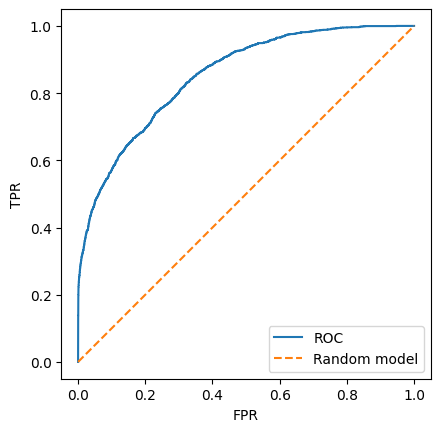

In [145]:
# ROC curve

fig, ax = plt.subplots(1, 1)
ax.plot(fpr, tpr, label="ROC")
ax.plot([0, 1], [0, 1],linestyle='--', label="Random model") 
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_box_aspect(1)
ax.legend()
plt.show()

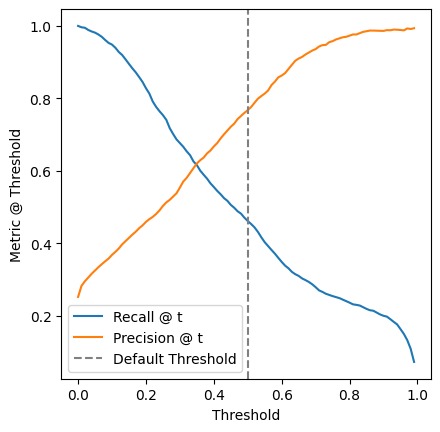

In [146]:
# We can compare Recall and Precision

prob_pred = model_RF.predict_proba(X_test)[:, 1]
thresholds = np.arange(0.0, 1.0, step=0.01)
recall_scores = [metrics.recall_score(Y_test, prob_pred > t) for t in thresholds]
precis_scores = [metrics.precision_score(Y_test, prob_pred > t) for t in thresholds]
fig, ax = plt.subplots(1, 1)
ax.plot(thresholds, recall_scores, label="Recall @ t")
ax.plot(thresholds, precis_scores, label="Precision @ t")
ax.axvline(0.5, c="gray", linestyle="--", label="Default Threshold")
ax.set_xlabel("Threshold")
ax.set_ylabel("Metric @ Threshold")
ax.set_box_aspect(1)
ax.legend()
plt.show()

### What is the optimum number of trees?

Overfitting does not depend on the number of trees, but we don´t want to run with more trees than necessary: computational cost
<BR> Therefore, we are going to calculate accuracies for models with different number of trees

In [149]:
train_scores = []
cv_scores    = []

estimator_range = range(30, 250, 20) #from 5 trees to 100, step 5

for n_estimators in estimator_range:
    model_RF = RandomForestClassifier(
                n_estimators = n_estimators,
                max_features = 6, # the previous optimum
                oob_score    = False,
                n_jobs       = -1, 
                random_state = 0,
                min_samples_leaf=2
             )
    
    model_RF.fit(X_train, Y_train)
    predictions = model_RF.predict(X_test)
    acc=accuracy_score(Y_test, predictions)
    print("% Accuracy of test dataset for {} trees is {:.3f}".format(n_estimators, acc))
    train_scores.append(acc) # storing accuracy from each iteration

    # and we also store the accuracy mean obtained from running a 5-fold validation
    cvscores = cross_val_score(
                estimator = model_RF,
                X         = X_train,
                y         = Y_train,
                scoring   = 'accuracy',
                cv        = 5
             )
    cv_scores.append(cvscores.mean()) 

% Accuracy of test dataset for 30 trees is 0.828
% Accuracy of test dataset for 50 trees is 0.830
% Accuracy of test dataset for 70 trees is 0.830
% Accuracy of test dataset for 90 trees is 0.830
% Accuracy of test dataset for 110 trees is 0.831
% Accuracy of test dataset for 130 trees is 0.831
% Accuracy of test dataset for 150 trees is 0.831
% Accuracy of test dataset for 170 trees is 0.830
% Accuracy of test dataset for 190 trees is 0.830
% Accuracy of test dataset for 210 trees is 0.830
% Accuracy of test dataset for 230 trees is 0.831


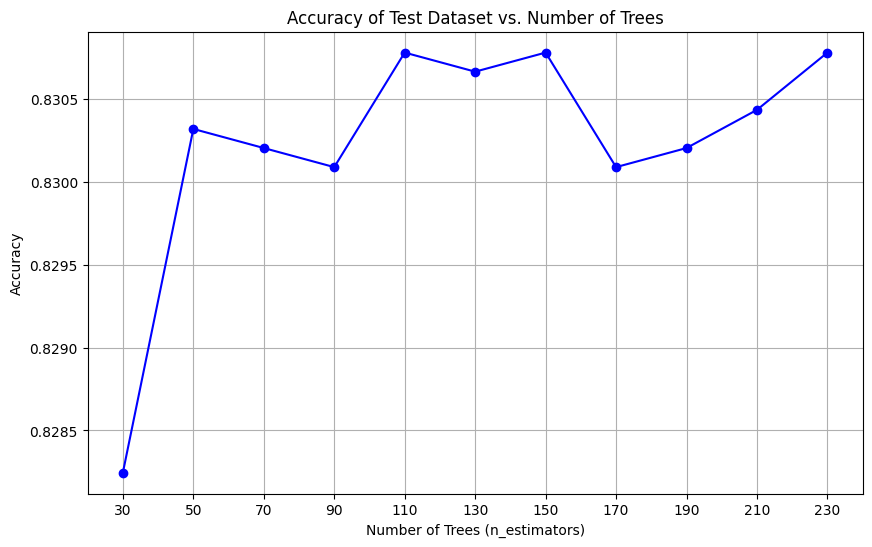

In [150]:
plt.figure(figsize=(10, 6))
plt.plot(estimator_range, train_scores, marker='o', linestyle='-', color='b')
plt.title('Accuracy of Test Dataset vs. Number of Trees')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')
plt.xticks(estimator_range)  # Para mostrar todos los valores en el eje x
plt.grid()
plt.show()

And we can also compute the CV error for several numbers of trees

Optimum number of trees: 130


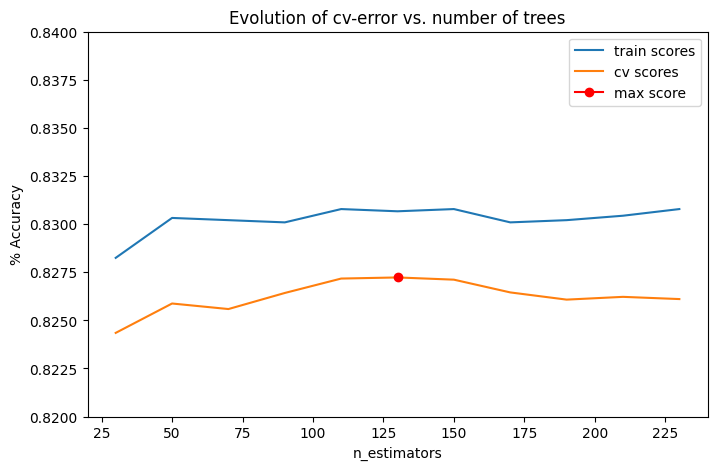

In [152]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmax(cv_scores)], max(cv_scores),
        marker='o', color = "red", label="max score")
ax.set_ylim(0.82, 0.84)
ax.set_ylabel("% Accuracy")
ax.set_xlabel("n_estimators")
ax.set_title("Evolution of cv-error vs. number of trees")
plt.legend();
print(f"Optimum number of trees: {estimator_range[np.argmax(cv_scores)]}")

In [153]:
# Random Forest
improved_model_RF = RandomForestClassifier(n_estimators = 130, 
                               random_state = 0,
                               max_features = best_params['max_features'],
                               n_jobs = -1,
                               oob_score = True,
                               criterion = best_params['criterion'],
                               min_samples_leaf = best_params['min_samples_leaf'])
improved_model_RF.fit(X_train,Y_train)

# predictions
y_pred_improved_rf_test = improved_model_RF.predict(X_test)

In [154]:
print("Accuracy for Improved Random Forest = {0:.2%}".format(accuracy_score(Y_test, y_pred_improved_rf_test)))

improved_rf_acc=accuracy_score(Y_test,y_pred_improved_rf_test)

Accuracy for Improved Random Forest = 83.02%


# XGBoost

In [156]:
data_dmatrix = xgb.DMatrix(data=X, label=y)

xg_clas = xgb.XGBClassifier(objective='binary:logistic', n_estimators=50)
xg_clas.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [157]:
preds = xg_clas.predict(X_train)
preds_test = xg_clas.predict(X_test)
xg_init_train_acc = accuracy_score(Y_train, preds)
xg_init_test_acc = accuracy_score(Y_test, preds_test)
print("Attempt 1 Train accuracy: %f" % (xg_init_train_acc))
print("Attmept 1 Test accuracy: %f" % (xg_init_test_acc))

Attempt 1 Train accuracy: 0.848626
Attmept 1 Test accuracy: 0.840456


In [160]:
gbm_param_grid = {'learning_rate': [0.01, 0.1, 0.2], 'subsample':[0.3,0.4,0.5]} #subsample controls % of data used
gbm = xgb.XGBClassifier()

grid_acc = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid, scoring='accuracy', cv=5, verbose=2)
grid_acc.fit(X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ..................learning_rate=0.01, subsample=0.3; total time=   0.3s
[CV] END ..................learning_rate=0.01, subsample=0.3; total time=   0.4s
[CV] END ..................learning_rate=0.01, subsample=0.3; total time=   0.5s
[CV] END ..................learning_rate=0.01, subsample=0.3; total time=   0.4s
[CV] END ..................learning_rate=0.01, subsample=0.3; total time=   0.3s
[CV] END ..................learning_rate=0.01, subsample=0.4; total time=   0.3s
[CV] END ..................learning_rate=0.01, subsample=0.4; total time=   0.4s
[CV] END ..................learning_rate=0.01, subsample=0.4; total time=   0.5s
[CV] END ..................learning_rate=0.01, subsample=0.4; total time=   0.3s
[CV] END ..................learning_rate=0.01, subsample=0.4; total time=   0.3s
[CV] END ..................learning_rate=0.01, subsample=0.5; total time=   0.5s
[CV] END ..................learning_rate=0.01, su

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'subsample': [0.3, 0.4, 0.5]},
             scoring='accuracy', verbose=2)

In [161]:
#Print best performing parameters and their RMSE scores
print('Best parameters found: ', grid_acc.best_params_)
print('Highest accuracy found: ', grid_acc.best_score_)

Best parameters found:  {'learning_rate': 0.1, 'subsample': 0.5}
Highest accuracy found:  0.8395963136825644


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

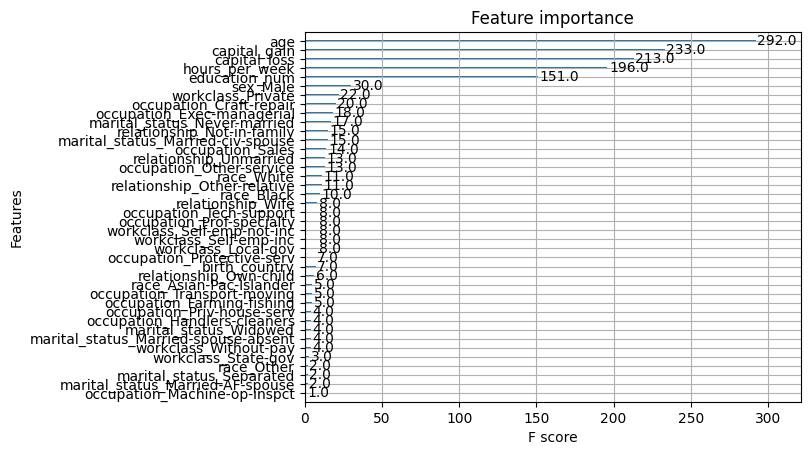

In [162]:
xgb.plot_importance(xg_clas, importance_type="weight")

# weight: number of times the variable has been used
# gain: average gain whenever variable is used
# cover: how many samples were affected by using each variable

# Plot all accuracies

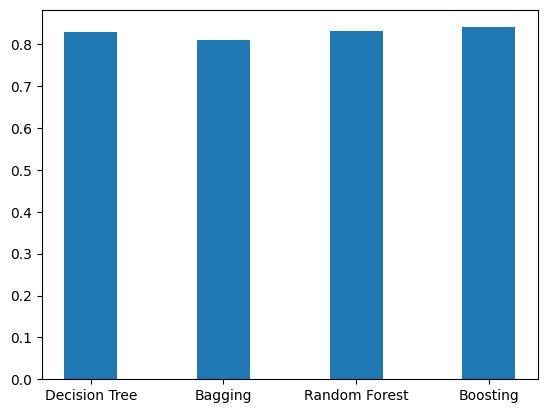

In [163]:
plt.bar([1,3,5,7], height=[tree_acc, bagging_acc, rf_acc, xg_init_test_acc], tick_label=['Decision Tree','Bagging','Random Forest', 'Boosting'])

plt.show()